In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import time
import math
from datetime import datetime
root=''
# try:
#   from google.colab import drive
#   drive.mount('/content/drive')
#   root='./drive/MyDrive/gnn/data/'
# except:
#   pass
# device='cuda' if torch.cuda.is_available() else 'cpu'
# print(torch.cuda.get_device_name(0))
# torch.cuda.empty_cache()

# 檢查是否有可用的 GPU，否則使用 CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
root = 'C:/Users/USER/Desktop/GNN_OPF_electricity_market-main/GNN_OPF_electricity_market-main/GNN_OPF_electricity_market-main/data_gen/118_data/'
# C:\Users\USER\Desktop\GNN_OPF_electricity_market-main\GNN_OPF_electricity_market-main\GNN_OPF_electricity_market-main\data_gen\118_data\118dc_quad_ISF.txt
filename = root + '118dc_quad_ISF.txt'

S_isf=pd.read_table(filename,sep=',',header=None).to_numpy() # ISF matrix
filename=root+'118ac_fmax.txt'
f_max=pd.read_table(filename,sep=',',header=None).to_numpy() # flow limit
n_line = np.size(S_isf,0)
S = torch.from_numpy(S_isf).to(device) # ISF
f_max = torch.from_numpy(f_max).to(device) # flow limit
print(S.shape,f_max.shape,torch.min(f_max))

x=np.load(root+'ac118_p10_x_v.npy')
y=np.load(root+'ac118_p10_y_v.npy')
W=np.load(root+'ac118_p10_w.npy')
print(np.max(x),np.min(x),np.max(y),np.min(y))

# scaling on voltage
vy_deviation = 0.9
vy_scale = 100
y[:,1,:] = (y[:,1,:] - vy_deviation) * vy_scale
print('voltage range(scaled):',np.min(y[:,1,:]),np.max(y[:,1,:]))

# scaling on price
pi_deviation = 0
y[:,0,:] = y[:,0,:] + pi_deviation
# filter out extreme points in price
y_sort_arg = np.argsort(np.amax(np.abs(y[:,0,:]),axis=0)) # max extreme
y_sort_arg1 = np.argsort(np.amin(y[:,0,:],axis=0),axis=0) # min extreme

del_idx0 = []
del_num = 0
for i in range(del_num):
  del_idx0.append(y_sort_arg[-i])
  del_idx0.append(y_sort_arg1[i])
# print(del_idx0)
del_idx = [] # keep only non-repeated
[del_idx.append(x) for x in del_idx0 if x not in del_idx]
del_idx = np.sort(del_idx)
# delete extreme points
print('price range old:',np.min(y[:,0,:]),np.max(y[:,0,:]))
print('voltage range old:',np.min(y[:,1,:]),np.max(y[:,1,:]))
# x = np.delete(x, del_idx, axis=2)
# y = np.delete(y, del_idx, axis=2)
print('price range new:',np.min(y[:,0,:]),np.max(y[:,0,:]))
print('voltage range new:',np.min(y[:,1,:]),np.max(y[:,1,:]))
print(x.shape,y.shape)

torch.Size([186, 118]) torch.Size([186, 1]) tensor(72)
1654.8 -332.4 949.67 0.94
voltage range(scaled): 3.9999999999999925 16.000000000000004
price range old: 11.547 949.67
voltage range old: 3.9999999999999925 16.000000000000004
price range new: 11.547 949.67
voltage range new: 3.9999999999999925 16.000000000000004
(118, 6, 10000) (118, 2, 10000)


In [3]:
root = 'C:/Users/USER/Desktop/GNN_OPF_electricity_market-main/GNN_OPF_electricity_market-main/GNN_OPF_electricity_market-main/data_gen/118_data/'
# C:\Users\USER\Desktop\GNN_OPF_electricity_market-main\GNN_OPF_electricity_market-main\GNN_OPF_electricity_market-main\data_gen\118_data\118dc_quad_ISF.txt
filename = root + '118dc_quad_ISF.txt'

S_isf=pd.read_table(filename,sep=',',header=None).to_numpy() # ISF matrix
filename=root+'118ac_fmax.txt'
f_max=pd.read_table(filename,sep=',',header=None).to_numpy() # flow limit
n_line = np.size(S_isf,0)
S = torch.from_numpy(S_isf).to(device) # ISF
f_max = torch.from_numpy(f_max).to(device) # flow limit
print(S.shape,f_max.shape,torch.min(f_max))

x=np.load(root+'ac118_p10_x_v.npy')
y=np.load(root+'ac118_p10_y_v.npy')
W=np.load(root+'ac118_p10_w.npy')
print(np.max(x),np.min(x),np.max(y),np.min(y))

# scaling on voltage
vy_deviation = 0.9
vy_scale = 100
y[:,1,:] = (y[:,1,:] - vy_deviation) * vy_scale
print('voltage range(scaled):',np.min(y[:,1,:]),np.max(y[:,1,:]))

# scaling on price
pi_deviation = 0
y[:,0,:] = y[:,0,:] + pi_deviation
# filter out extreme points in price
y_sort_arg = np.argsort(np.amax(np.abs(y[:,0,:]),axis=0)) # max extreme
y_sort_arg1 = np.argsort(np.amin(y[:,0,:],axis=0),axis=0) # min extreme

del_idx0 = []
del_num = 0
for i in range(del_num):
  del_idx0.append(y_sort_arg[-i])
  del_idx0.append(y_sort_arg1[i])
# print(del_idx0)
del_idx = [] # keep only non-repeated
[del_idx.append(x) for x in del_idx0 if x not in del_idx]
del_idx = np.sort(del_idx)
# delete extreme points
print('price range old:',np.min(y[:,0,:]),np.max(y[:,0,:]))
print('voltage range old:',np.min(y[:,1,:]),np.max(y[:,1,:]))
# x = np.delete(x, del_idx, axis=2)
# y = np.delete(y, del_idx, axis=2)
print('price range new:',np.min(y[:,0,:]),np.max(y[:,0,:]))
print('voltage range new:',np.min(y[:,1,:]),np.max(y[:,1,:]))
print(x.shape,y.shape)

torch.Size([186, 118]) torch.Size([186, 1]) tensor(72)
1654.8 -332.4 949.67 0.94
voltage range(scaled): 3.9999999999999925 16.000000000000004
price range old: 11.547 949.67
voltage range old: 3.9999999999999925 16.000000000000004
price range new: 11.547 949.67
voltage range new: 3.9999999999999925 16.000000000000004
(118, 6, 10000) (118, 2, 10000)


In [4]:
n_sample=y.shape[-1]
n_bus=y.shape[0]
x_total=x.transpose((1,0,2)).reshape(-1,x.shape[-1])
y_total=y.transpose((1,0,2)).reshape(-1,y.shape[-1])
x_train,x_test,y_train,y_test=train_test_split(x_total.T,y_total.T,test_size=0.2)


class Dataset(torch.utils.data.Dataset):
    def __init__(self,x,y):
        self.x=torch.from_numpy(x).float()
        self.y=torch.from_numpy(y).float()
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx=idx.tolist()
        return self.x[idx],self.y[idx]
    
batch_size=512
#512
params={'batch_size': batch_size,
        'shuffle': True,
        'num_workers': 0}
train=Dataset(x_train,y_train)
train_set=torch.utils.data.DataLoader(train,**params)
val=Dataset(x_test,y_test)
val_set=torch.utils.data.DataLoader(val,**params)

In [5]:
# 資料分析
# 從資料集中建立 DataLoader
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

# 取第一個 batch 進行分析
train_batch_x, _ = next(iter(train_loader))
val_batch_x, _ = next(iter(val_loader))

# 計算均值和標準差
print(train_batch_x.shape)
train_mean, train_std = train_batch_x.mean(dim=0), train_batch_x.std(dim=0)
val_mean, val_std = val_batch_x.mean(dim=0), val_batch_x.std(dim=0)

mean_value_train = train_mean.mean().item()
print('Train Mean:', mean_value_train)
std_value_train = train_std.mean().item()
print('Train Std:', std_value_train)
mean_value_val = val_mean.mean().item()
print('Validation Mean:', mean_value_val)
std_value_val = val_std.mean().item()
print('Validation Std:', std_value_val)


torch.Size([512, 708])
Train Mean: 6.476999282836914
Train Std: 3.7040112018585205
Validation Mean: 6.432124614715576
Validation Std: 3.668586015701294


In [6]:
# fig2 = plt.figure(figsize=(8,4))
# flat_list = list(np.concatenate(y[:,n_sample:]).flat)
# flat_list3 = list(np.concatenate(y[:,:n_sample]).flat)
# plt.subplot(1,2,1)
# plt.hist(flat_list,bins = 100,label = 'voltage')
# plt.subplot(1,2,2)
# # plt.hist(flat_list3,range=[-2000, 2000],bins = 100,label = 'price')
# plt.hist(flat_list3,bins = 100,label = 'price')
# plt.show()

In [7]:

class dnn(torch.nn.Module):
  def __init__(self,shape):
    super(dnn,self).__init__()
    layers=[]
    for idx in range(len(shape)-2):
      layers.extend([
        nn.Linear(shape[idx],shape[idx+1]),
        nn.BatchNorm1d(shape[idx+1]),
        nn.ReLU(),
        nn.Dropout(0.5),
      ])
    layers+=[nn.Linear(shape[-2],shape[-1])]
    self.features=nn.Sequential(*layers)
    for temp in self.features:
      if type(temp)==nn.Linear:
        torch.nn.init.normal_(temp.weight,mean=0,std=1)
  def forward(self,x): return self.features(x)
#net=dnn([n_bus*6,n_bus*10,n_bus*10,n_bus*10,n_bus*2]).to(device)
#print('number of params: %d'%(sum(temp.numel() for temp in net.parameters() if temp.requires_grad)))




In [8]:
# class dnn(torch.nn.Module):
#   def __init__(self,shape,dropout=0):
#     super(dnn,self).__init__()
#     layers=[]
#     for idx in range(len(shape)-2):
#       layers.extend([
#         nn.Linear(shape[idx],shape[idx+1]),
#         nn.ReLU(),
#         nn.BatchNorm1d(shape[idx+1]),
#         nn.Dropout(dropout)
#       ])
#     layers.append(nn.Linear(shape[-2],shape[-1]))
#     self.features=nn.Sequential(*layers)
#     # initialize
#     for temp in self.features:
#       if type(temp)==nn.Linear:
#         torch.nn.init.normal_(temp.weight,mean=0,std=1)
#   def forward(self,x):
#     return self.features(x)
# net=dnn([118*6,118*5,118*5,118*10,118*10,118*10,118*10,118]).to(device)
# print('number of params: %d'%(sum(temp.numel() for temp in net.parameters() if temp.requires_grad)))
from torchsummary import summary
class dnn(torch.nn.Module):
    def __init__(self, shape):
        super(dnn, self).__init__()
        layers = []
        for idx in range(len(shape) - 2):
            layers.extend([
                nn.Linear(shape[idx], shape[idx+1]),
                nn.BatchNorm1d(num_features=shape[idx+1]),  # 確保 num_features 正確
                nn.ReLU(),
                nn.Dropout(0.5),
            ])
        layers.append(nn.Linear(shape[-2], shape[-1]))  # 最後一層
        self.features = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 保證 batch_size 在第一維
        return self.features(x)

# 測試模型
print('n_bus:',n_bus)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#net=dnn([n_bus*6,n_bus*10,n_bus*10,n_bus*10,n_bus*2]).to(device) #source code
net = dnn([n_bus*6, n_bus*5, n_bus*5, n_bus*10, n_bus*10, n_bus*10, n_bus*10, n_bus*2]).to(device)#my code


# 打印總參數數量
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params:,}")

summary(net, (1, n_bus*6))


n_bus: 118
Total Parameters: 5,935,636
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 590]         418,310
       BatchNorm1d-2                  [-1, 590]           1,180
              ReLU-3                  [-1, 590]               0
           Dropout-4                  [-1, 590]               0
            Linear-5                  [-1, 590]         348,690
       BatchNorm1d-6                  [-1, 590]           1,180
              ReLU-7                  [-1, 590]               0
           Dropout-8                  [-1, 590]               0
            Linear-9                 [-1, 1180]         697,380
      BatchNorm1d-10                 [-1, 1180]           2,360
             ReLU-11                 [-1, 1180]               0
          Dropout-12                 [-1, 1180]               0
           Linear-13                 [-1, 1180]       1,393,580


In [9]:
# threshold function for p_g
class my_gen_pred_binary(nn.Module):
  def __init__(self):
    super(my_gen_pred_binary,self).__init__()
  def forward(self,x,thresh):
    right_thresh=thresh.clone().detach().requires_grad_(True).double()
    left_thresh=torch.tensor(0).double()
    x=x.double()
    output = torch.sigmoid(left_thresh - x)
    output = torch.mul(output,left_thresh - x) + x
    output = torch.sigmoid(output - right_thresh)
    output = torch.mul(output,output - right_thresh) + right_thresh
    return output

In [10]:
## params needed for S calculation
# line parameters
filename1 = root+'ieee118_lineloc.txt'
filename2 = root+'ieee118_lineparams.txt'
filename3 = root+'ieee118_Bmat.txt'
# incidence info
line_loc = pd.read_table(filename1,sep=',',header=None).to_numpy()
# r, x, shunt, S_max
line_params = pd.read_table(filename2,sep=',',header=None).to_numpy()
B_mat=pd.read_table(filename3,sep=',',header=None).to_numpy()
B_r = np.delete(B_mat,68,axis=0)
B_r = np.delete(B_r,68,axis=1)
Br_inv = np.linalg.inv(B_r)

R_line = line_params[:,0].copy()
X_line = line_params[:,1].copy()

B_shunt = line_params[:,2].copy()

Z_line = R_line + 1j * X_line 
Y_line = 1 / Z_line

G_line = np.real(Y_line)
B_line = np.imag(Y_line)

# transformer indicator
a = (R_line > 0).astype(int)

# params to tensor and GPU
G_line_tensor = torch.from_numpy(G_line).to(device) # conductance
B_line_tensor = torch.from_numpy(B_line).to(device) # susceptance
B_shunt_tensor = torch.from_numpy(B_shunt/2).to(device) # conductance
Br_inv_tensor = torch.from_numpy(Br_inv).to(device) # reduced Bbus matrix
a_tensor = torch.from_numpy(a).double().to(device) # line/transformer

In [11]:
class loss_func:
    def __init__(self,s_max,G_line,B_line,B_shunt,Br_inv,a,line_loc):
      self.s=s_max
      self.g=G_line
      self.b=B_line
      self.c=B_shunt
      self.r=Br_inv
      self.a=a
      self.mse=nn.MSELoss() # MSE loss
      self.lmda1=torch.tensor(10).to(device) # V MSE 
      self.lmda2=torch.tensor(1).to(device) # pi MSE 
      self.lmda3=torch.tensor(0.1).to(device) # v l_inf
      self.lmda4=torch.tensor(0.1).to(device) # s feasibility
      self.lmda5=torch.tensor(0.01).to(device) # pi l_inf
      self.line_loc=line_loc
      self.binary_cell=my_gen_pred_binary()
    def calc(self,pred,label,x,feas):
      mse_p=self.mse(pred[:,:n_bus],label[:,:n_bus])
      mse_v=self.mse(pred[:,n_bus:],label[:,n_bus:])
      linf_p=(pred[:,:n_bus]-label[:,:n_bus]).norm(p=float('inf'))
      linf_v=(pred[:,n_bus:]-label[:,n_bus:]).norm(p=float('inf'))
      if feas==False:
        return self.lmda1*mse_v+self.lmda2*mse_p+self.lmda3*linf_v+self.lmda5*linf_p
      label_pred=pred[:,:n_bus]
      p_max=x[:,:n_bus*1]-x[:,n_bus*1:n_bus*2]
      quadratic_b=x[:,n_bus*4:n_bus*5]
      quadratic_a=x[:,n_bus*5:n_bus*6]
      quadratic_center=(label_pred-quadratic_b)/(quadratic_a+1e-5)/2
      p_inj=self.binary_cell(quadratic_center,p_max)
      bus_inj=p_inj+x[:,n_bus:n_bus*2]
      p_inj_r=torch.cat((bus_inj[:,:68],bus_inj[:,69:]),1)/100
      theta0=torch.matmul(self.r,p_inj_r.T)
      ref_ang=torch.zeros(1,theta0.shape[1]).to(device)
      theta=torch.cat([theta0[:68,:],ref_ang,theta0[68:,:]],0)
      v_pred=(pred[:,n_bus:].transpose(0,1))*0.01+0.9
      
      # s penalty
      theta1=theta[self.line_loc[:,0]-1,:]
      theta2=theta[self.line_loc[:,1]-1,:]
      V1=(v_pred[self.line_loc[:,0]-1,:]).double()
      V2=(v_pred[self.line_loc[:,1]-1,:]).double()
      f_p=(self.a*self.g*(V1*V1).T)-self.a*((V1*V2).T)*(self.g*torch.cos(theta1-theta2).T+self.b*torch.sin(theta1-theta2).T)
      f_p=f_p.T
      f_q=-self.a*(V1.T)*(self.a*V1.T)*(self.b+self.c/2)+self.a*((V1*V2).T)*(self.b*torch.cos(theta1-theta2).T-self.g*torch.sin(theta1-theta2).T)
      f_q=f_q.T
      s_pred=torch.sqrt(f_p*f_p+f_q*f_q+1e-5)*100
      s_penalty=torch.sigmoid(s_pred-self.s)+torch.sigmoid(-s_pred-self.s)
      s_total=torch.sum(s_penalty)

      # sji penalty
      theta1=theta[self.line_loc[:,1]-1,:]
      theta2=theta[self.line_loc[:,0]-1,:]
      V1=(v_pred[self.line_loc[:,1]-1,:]).double()
      V2=(v_pred[self.line_loc[:,0]-1,:]).double() 
      fji_p=(self.a*self.g*(V1*V1).T)-self.a*((V1*V2).T)*(self.g*torch.cos(theta1-theta2).T+self.b*torch.sin(theta1-theta2).T)
      fji_p=fji_p.T
      fji_q=-self.a*(V1.T)*(self.a*V1.T)*(self.b+self.c/2)+self.a*((V1*V2).T)*(self.b*torch.cos(theta1-theta2).T-self.g*torch.sin(theta1-theta2).T)
      fji_q=fji_q.T
      sji_pred=torch.sqrt(fji_p*fji_p+fji_q*fji_q+1e-5)*100
      sji_penalty=torch.sigmoid(sji_pred-self.s)+torch.sigmoid(-sji_pred-self.s)
      sji_total=torch.sum(sji_penalty)

      return self.lmda1*mse_v+self.lmda2*mse_p+self.lmda3*linf_v+self.lmda5*linf_p+self.lmda4*s_total+self.lmda4*sji_total
my_loss=loss_func(f_max,G_line_tensor,B_line_tensor,B_shunt_tensor,Br_inv_tensor,a_tensor,line_loc)

In [ ]:
import torch.optim as optim
path = root + 'data_118_quad/gnn_trained_ac118.pickle'
try:
    net.load_state_dict(torch.load(path))
    print('params loaded')
except:
    print('cold start')

# 初始學習率
lr = 0.001
factor = 0.9
patience = 5
optimizer = optim.AdamW(net.parameters(), lr)

# Learning Rate Scheduler: ReduceLROnPlateau
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     mode='min',       # 監測 loss，越小越好
#     factor=0.9,       # 學習率變成原來的 90%
#     patience=5,       # 5 個 epoch 沒有改善才降低學習率
#     verbose=True,     # 會輸出學習率變更訊息
#     min_lr=1e-6       # 學習率最低不低於 1e-6
# )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',       # 監測 loss
    factor=factor,       # 學習率變成 50% (下降更多)
    patience=patience,       # 3 個 epoch 沒有改善就降低學習率
    verbose=True,     
    min_lr=1e-6       
)



train_loss = []
val_loss = []
lr_list = []

t0 = time.time()
max_epochs = 300
eval_epoch = 5

tolerance = 5  # 早停耐心值
min_delta = 1e-3
previous = float('inf')

feas = False  # 加入可行性標記

for epoch in range(max_epochs):
    total_loss = 0.0
    for local_batch, local_label in train_set:
        optimizer.zero_grad()
        local_batch, local_label = local_batch.to(device), local_label.to(device)
        logits = net(local_batch)
        loss = my_loss.calc(logits, local_label, local_batch, feas)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_set.dataset)
    train_loss.append(avg_loss)
    lr_list.append(scheduler.optimizer.param_groups[0]['lr'])
    print(f"Epoch {epoch} | Training loss: {avg_loss:.4f} | Learning Rate: {scheduler.optimizer.param_groups[0]['lr']:.6f}")
    
    if epoch % eval_epoch == 0:
        net.eval()
        total_loss = 0.0
        for local_batch, local_label in val_set:
            local_batch, local_label = local_batch.to(device), local_label.to(device)
            logits = net(local_batch)
            loss = my_loss.calc(logits, local_label, local_batch, feas)
            total_loss += loss.item()
        avg_loss = total_loss / len(val_set.dataset)
        val_loss.append([epoch, avg_loss])
        print(f"Epoch {epoch} | Validation loss: {avg_loss:.4f} | Learning Rate: {scheduler.optimizer.param_groups[0]['lr']:.6f}")
        
        # 更新 learning rate
        scheduler.step(avg_loss)
        
        # 早停機制
        # if epoch:
        #     if previous - avg_loss < min_delta:
        #         tolerance -= 1
        #     if tolerance == 0:
        #         print("Early stopping triggered")
        #         break
        previous = avg_loss
        net.train()

        final_epoch = epoch

t1 = time.time()
print(f"Training time: {t1 - t0:.4f}s")
#印出 lr validation loss training loss 圖


cold start


c:\Users\USER\anaconda3\envs\AC_OPF\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0 | Training loss: 402.8470 | Learning Rate: 0.001000
Epoch 0 | Validation loss: 407.9184 | Learning Rate: 0.001000
Epoch 1 | Training loss: 387.7569 | Learning Rate: 0.001000
Epoch 2 | Training loss: 373.0236 | Learning Rate: 0.001000
Epoch 3 | Training loss: 357.0128 | Learning Rate: 0.001000
Epoch 4 | Training loss: 340.0839 | Learning Rate: 0.001000
Epoch 5 | Training loss: 320.8031 | Learning Rate: 0.001000
Epoch 5 | Validation loss: 272.8796 | Learning Rate: 0.001000
Epoch 6 | Training loss: 293.7709 | Learning Rate: 0.001000
Epoch 7 | Training loss: 263.6003 | Learning Rate: 0.001000
Epoch 8 | Training loss: 238.2100 | Learning Rate: 0.001000
Epoch 9 | Training loss: 214.2452 | Learning Rate: 0.001000
Epoch 10 | Training loss: 191.0469 | Learning Rate: 0.001000
Epoch 10 | Validation loss: 176.6790 | Learning Rate: 0.001000
Epoch 11 | Training loss: 168.8224 | Learning Rate: 0.001000
Epoch 12 | Training loss: 147.7256 | Learning Rate: 0.001000
Epoch 13 | Training loss: 128.

In [13]:
import os
import subprocess
from datetime import datetime
import numpy as np



# **設定輸出目錄**
output_dir = r'C:\Users\USER\Desktop\GNN_OPF_electricity_market-main\output_loss_fig\trainingloss_gunplot'
timestamp = datetime.now().strftime('%m%d%H%M')
output_file = os.path.join(output_dir, f'{timestamp}.txt')

# **確保目錄存在**
os.makedirs(output_dir, exist_ok=True)

print(len(train_loss), len(val_loss), len(lr_list))  # **確認長度**

# **儲存數據到 txt 檔案**
with open(output_file, 'w') as file:
    for i in range(len(train_loss)):
        if i % 5 == 0 and (i // 5) < len(val_loss):  # **確保 val_loss 沒有超出索引**
            val = val_loss[i // 5]  # **正確存入數值**
        else:
            val = "NaN"  # **改成 NaN 讓 Gnuplot 忽略**
        file.write(f"{i} {train_loss[i]} {val[1]} {lr_list[i]}\n")

print(f"✅ 輸出內容已儲存到 {output_file}")

# **修正 Windows 路徑格式**
gnuplot_file = output_file.replace("\\", "/")  # **確保 Gnuplot 能識別路徑**
loss_plot_path = os.path.join(output_dir, f'loss_plot_{timestamp}.png').replace("\\", "/")
lr_plot_path = os.path.join(output_dir, f'lr_plot_{timestamp}.png').replace("\\", "/")

# **定義 gnuplot 腳本**
gnuplot_script = f"""
set terminal pngcairo enhanced font 'Arial,12' size 800,600
set output "{loss_plot_path}"

set title "Training Loss & Validation Loss"
set xlabel "Step"
set ylabel "Value"
set grid
set key outside

# **確保 Validation Loss 顯示**
plot "{gnuplot_file}" using 1:2 with lines title "Train Loss" linecolor rgb "blue", \
     "{gnuplot_file}" using 1:3 with lines title "Val Loss" linecolor rgb "red"
   

# **第二張圖：Learning Rate**
set output "{lr_plot_path}"
set title "Learning Rate"
set xlabel "Step"
set ylabel "Learning Rate"
set grid
set key outside

# **繪製 Learning Rate**
plot "{gnuplot_file}" using 1:4 with lines title "Learning Rate" linecolor rgb "green" lw 2

"""



# **執行 gnuplot**
try:
    result = subprocess.run(["gnuplot"], input=gnuplot_script, text=True, check=True,
                            stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    if result.stderr:
        print("⚠️ Gnuplot Error:", result.stderr)
    else:
        print(f"✅ Plots generated successfully.\n📂 Loss plot: {loss_plot_path}")
except FileNotFoundError:
    print("❌ Error: Gnuplot is not installed or not in PATH.")
except subprocess.CalledProcessError as e:
    print(f"❌ Gnuplot execution failed:\n{e.stderr}")


300 60 300
✅ 輸出內容已儲存到 C:\Users\USER\Desktop\GNN_OPF_electricity_market-main\output_loss_fig\trainingloss_gunplot\02181120.txt
✅ Plots generated successfully.
📂 Loss plot: C:/Users/USER/Desktop/GNN_OPF_electricity_market-main/output_loss_fig/trainingloss_gunplot/loss_plot_02181120.png


In [14]:
from datetime import datetime

timestamp=datetime.now().strftime('%m%d%H%M')
path = 'C:\\Users\\USER\\Desktop\\GNN_OPF_electricity_market-main\\GNN_OPF_electricity_market-main\\GNN_OPF_electricity_market-main\\data_gen\\118_data\\FCNN_model\\'

path = path+'dnn_%s.pickle'%(timestamp)
if feas==False: path.replace('feas','')
print(path)
torch.save(net.state_dict(),path)





C:\Users\USER\Desktop\GNN_OPF_electricity_market-main\GNN_OPF_electricity_market-main\GNN_OPF_electricity_market-main\data_gen\118_data\FCNN_model\dnn_02181120.pickle


60


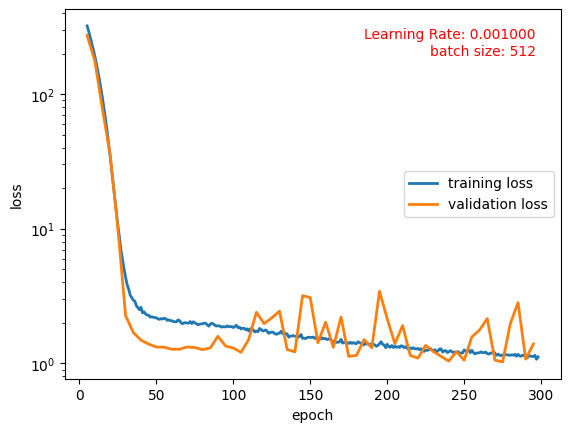

In [15]:



val_len = len(val_loss)
print(val_len)
val_plt = np.zeros((2,val_len))
for i in range(val_len):
  val_plt[0,i] = val_loss[i][0]
  val_plt[1,i] = val_loss[i][1]

plt.figure()
plot_idx = np.arange(np.size(train_loss))
plt.plot(plot_idx[5:-1],train_loss[5:-1],lw=2,label='training loss')
plt.plot(val_plt[0,1:],val_plt[1,1:],lw=2,label='validation loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

# 在圖的右上角標示學習率
plt.text(0.95, 0.95, f'Learning Rate: {lr:.6f}\nbatch size: {batch_size}', 
         transform=plt.gca().transAxes, fontsize=10, ha='right', va='top', color='red')




# 儲存圖片到指定資料夾（需提供路徑）
timestamp=datetime.now().strftime('%m%d%H%M')
output_path = r'C:\Users\USER\Desktop\GNN_OPF_electricity_market-main\output_loss_fig'
output_path = output_path + '/118ac_loss_fig_%s.png' % (timestamp)
plt.savefig(output_path, dpi=300, bbox_inches='tight')  # 儲存為 PNG 格式，解析度 300 dpi


plt.show(block=False)


# Evaluate the model w/ validation set

In [16]:
n_test = np.size(x_test,0)
x_test_feed = torch.from_numpy(x_test).float()
x_test_feed = x_test_feed#.transpose(1,2)
x_test_feed = x_test_feed.to(device)
print('Validation dataset size:',x_test_feed.shape)
print('Number of validation set: ',n_test)
y_pred = net(x_test_feed)
print(y_pred.shape)

Validation dataset size: torch.Size([2000, 708])
Number of validation set:  2000
torch.Size([2000, 236])


* Visualization




 - Visualize errors

In [17]:
y_pred1 = y_pred.cpu().detach()
y_pred1 = torch.squeeze(y_pred1,1).numpy()#.transpose()
print(y_test.shape,y_pred1.shape)

(2000, 236) (2000, 236)


In [18]:
# x=np.reshape(x,(x.shape[0]*x.shape[1],x.shape[2])) # reshape by samples not dim1
# y=np.reshape(y,(y.shape[0]*y.shape[1],y.shape[2]))
# print(x_pre.shape,y_pre.shape)

y_pred_temp = y_pred1.copy().transpose()
# y_pred2=np.reshape(y_pred2,(y_pre.shape[0],y_pre.shape[1],n_test))
y_pred2=np.zeros([y.shape[0],y.shape[1],n_test])
y_pred2[:,0,:]=y_pred_temp[:n_bus,:]
y_pred2[:,1,:]=y_pred_temp[n_bus:,:]
print(y_pred2.shape,y_pred1.shape)

y_test_temp = y_test.copy().transpose()
# y_pred2=np.reshape(y_pred2,(y_pre.shape[0],y_pre.shape[1],n_test))
y_test2=np.zeros([y.shape[0],y.shape[1],n_test])
y_test2[:,0,:]=y_test_temp[:n_bus,:]
y_test2[:,1,:]=y_test_temp[n_bus:,:]
y_pred1 = y_pred2.copy()

(118, 2, 2000) (2000, 236)


In [19]:
# recover the original p.u. scale
# vy_deviation) * vy_scale
y_pred1[:,1,:] = y_pred1[:,1,:] / vy_scale + vy_deviation
y_test2[:,1,:] = y_test2[:,1,:] / vy_scale + vy_deviation
print(y_test2.shape,y_pred1.shape)

(118, 2, 2000) (118, 2, 2000)


In [20]:
n_test = np.size(y_test2,2)
err_L2 = np.zeros(n_test)
err_Linf = np.zeros(n_test)
for i in range(n_test):
  err_L2[i] = np.linalg.norm(y_test2[:,0,i] - y_pred1[:,0,i]) / np.linalg.norm(y_test2[:,0,i])
  err_Linf[i] = np.max(np.abs(y_test2[:,0,i] - y_pred1[:,0,i])) / np.max(np.abs(y_test2[:,0,i]))

err_L2_v = np.zeros(n_test)
err_Linf_v = np.zeros(n_test)
for i in range(n_test):
  err_L2_v[i] = np.linalg.norm(y_test2[:,1,i] - y_pred1[:,1,i]) / np.linalg.norm(y_test2[:,1,i])
  err_Linf_v[i] = np.max(np.abs(y_test2[:,1,i] - y_pred1[:,1,i])) / np.max(np.abs(y_test2[:,1,i]))

In [21]:
err_L2_mean = np.mean(err_L2)
err_Linf_mean = np.mean(err_Linf)
print('Price L2 mean:', err_L2_mean,'L_inf mean:', err_Linf_mean )
err_L2_mean_v = np.mean(err_L2_v)
err_Linf_mean_v = np.mean(err_Linf_v)
print('Voltage L2 mean:', err_L2_mean_v,'L_inf mean:', err_Linf_mean_v )

# fig2 = plt.figure(figsize=(16, 16))
# plt.subplot(2, 2, 1)
# # plt.hist(np.abs(ga),bins = 10)
# plt.plot(err_L2,'bo',markersize=0.5,label = 'L2 error')
# plt.plot(err_Linf,'r^',markersize=0.5,label = 'Linf error')
# plt.legend(loc="upper right")
# plt.xlabel('sample index')
# plt.ylabel('error')
# plt.title('Normalized sample error')
# plt.grid(True)
# # error histogram
# plt.subplot(2, 2, 2)
# plt.hist(err_L2, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
# plt.hist(err_Linf, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
# plt.legend(loc="upper right")
# plt.xlabel('sample error value')
# plt.ylabel('frequency')
# plt.title('Histogram of L_2 error')
# # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.grid(True)

# plt.subplot(2, 2, 3)
# # plt.hist(np.abs(ga),bins = 10)
# plt.plot(err_L2_v,'bo',markersize=0.5,label = 'L2 error')
# plt.plot(err_Linf_v,'r^',markersize=0.5,label = 'Linf error')
# plt.legend(loc="upper right")
# plt.xlabel('sample index')
# plt.ylabel('error')
# plt.title('Normalized sample error')
# plt.grid(True)
# # error histogram
# plt.subplot(2, 2, 4)
# plt.hist(err_L2_v, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
# plt.hist(err_Linf_v, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
# plt.legend(loc="upper right")
# plt.xlabel('sample error value')
# plt.ylabel('frequency')
# plt.title('Histogram of L_2 error')
# # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.grid(True)
# plt.show()

Price L2 mean: 0.0554743482234698 L_inf mean: 0.06359566486968149
Voltage L2 mean: 0.005736061124148106 L_inf mean: 0.017060354212589984


In [22]:
print(y_pred1[:,1,:n_test].shape,y_test2[:,1,:n_test].shape)
print('true range:',np.max(y_test2[:,1,:n_test]),np.min(y_test2[:,1,:n_test]))
print('predicted range',np.max(y_pred1[:,1,:n_test]),np.min(y_pred1[:,1,:n_test]))

# fig3 = plt.figure(figsize=(16, 8))
# flat_list1 = list(np.concatenate(y_test2[:,1,:n_test]).flat)
# flat_list2 = list(np.concatenate(y_pred1[:,1,:n_test]).flat)
# plt.hist(flat_list1,bins = 100,label = 'true')

# plt.hist(flat_list2,bins = 100,label = 'pred')
# plt.legend(loc="upper right")
# plt.grid(True)
# plt.show()

(118, 2000) (118, 2000)
true range: 1.06 0.94
predicted range 1.0878542709350587 0.9313497233390808


In [23]:
print(x.shape,n_sample)

x_new = np.zeros([x.shape[0],x.shape[1],n_sample])
for i in range(x.shape[1]):
  x_new[:,i,:] = x_total[n_bus*i:n_bus*(i+1),:]

y_new = np.zeros([y.shape[0],y.shape[1],n_sample])
for i in range(y.shape[1]):
  y_new[:,i,:] = y_total[n_bus*i:n_bus*(i+1),:]

(118, 6, 10000) 10000


# Predict generation using $\pi$
* Using predicted $\pi$ and find the active constraints in $p_G(i)$
* For inactive $p_G(i)$ consider other methods like power flow balance

In [24]:
gen_limit0 = x_new[:,4,:].copy() # lin cost
print(gen_limit0.shape)

gen_idx = []
gen_idx = np.arange(n_bus)
# for i in range(n_bus):
#   if gen_limit0[i,0] > 0:
#     gen_idx.append(i)
print(type(gen_idx),len(gen_idx),gen_idx)

(118, 10000)
<class 'numpy.ndarray'> 118 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117]


In [25]:
n_sample=x_total.shape[-1]
x_feed = torch.from_numpy(x_total.T).float()
y_pred1=net(x_feed.to(device)).cpu().detach().numpy().T
y_pred_temp = y_pred1.copy()
y_pred2=np.zeros([y.shape[0],y.shape[1],n_sample])
y_pred2[:,0,:]=y_pred_temp[:n_bus,:]
y_pred2[:,1,:]=y_pred_temp[n_bus:,:]
print(y_pred2.shape,y_pred1.shape)
y_pred1 = y_pred2.copy()

(118, 2, 10000) (236, 10000)


In [26]:
gen_cost0 = x_new[:,4,:].copy()
lmp_data = y_new[:,0,:].copy()
quadratic_a = x_new[:,5,:].copy()
profit_pred = y_pred1[:,0,:] - gen_cost0
print(np.min(np.abs(profit_pred)))
profit_true = lmp_data - gen_cost0
print(np.min(np.abs(profit_true)))
profit_pred=(y_pred1[:,0,:]-gen_cost0)/(quadratic_a+1e-10)/2
profit_true=(lmp_data-gen_cost0)/(quadratic_a+1e-10)/2
print(np.min(np.abs(profit_pred)))
print(np.min(np.abs(profit_true)))

0.0010632171630859943
0.784000000000006
0.3804287313435779
0.24221453285700786


In [27]:
print(profit_pred.shape,profit_true.shape)
profit_err = profit_true - profit_pred
profit_err_l2 = np.zeros([n_sample,1])

for i in range(n_sample):
  profit_err_l2[i] = np.linalg.norm(profit_err[:,i])/np.linalg.norm(profit_true[:,i])
print(np.mean(profit_err_l2))

# fig5 = plt.figure(figsize=(16, 8))
# # error histogram
# plt.hist(profit_err_l2, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
# # plt.hist(err_linf_new, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
# plt.legend(loc="upper right")
# plt.xlabel('sample error value')
# plt.ylabel('frequency')
# plt.title('Histogram of L_2 error')
# # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.grid(True)
# plt.show()

(118, 10000) (118, 10000)
0.04557398942388041


In [28]:
p_pred_sort = np.reshape(profit_pred,n_bus*n_sample)
p_true_sort = np.reshape(profit_true,n_bus*n_sample)
print(p_pred_sort.shape)
print(np.min(p_pred_sort),np.min(p_true_sort))

(1180000,)
-954.4922588259392 -2.9391182643149665


In [29]:
# fig2 = plt.figure(figsize=(8, 8))
# plt.hist(p_pred_sort, bins = 50, facecolor='b', alpha=0.75,label = 'pred. profit')
# plt.hist(p_true_sort, bins = 50, facecolor='g', alpha=0.75,label = 'true profit')
# plt.legend(loc="upper right")
# plt.xlabel('value')
# plt.ylabel('frequency')
# plt.title('profit histogram')
# # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.grid(True)
# plt.show()

In [30]:
# x = [load, gen_cost, gen_lim]
binary_thres_true = 1e-5
binary_thres = x_new[:,0,:].copy() # upper
binary_thres_lo = x_new[:,1,:].copy() # lower
gen_pred_binary_full = np.zeros((n_bus,n_sample))
gen_true_binary_full = np.zeros((n_bus,n_sample))

for i in range(n_sample):
  for j in range(len(gen_idx)):
    # predicted generator limit
    if profit_pred[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
      gen_pred_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
    elif profit_pred[gen_idx[j],i] < binary_thres_lo[gen_idx[j],i]:
      gen_pred_binary_full[gen_idx[j],i] = binary_thres_lo[gen_idx[j],i]
    else:
      gen_pred_binary_full[gen_idx[j],i] = profit_pred[gen_idx[j],i]
    # true generator limit
    if profit_true[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
      gen_true_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
    elif profit_true[gen_idx[j],i] < binary_thres_lo[gen_idx[j],i]:
      gen_true_binary_full[gen_idx[j],i] = binary_thres_lo[gen_idx[j],i]
    else:
      gen_true_binary_full[gen_idx[j],i] = profit_true[gen_idx[j],i]

gen_inj=gen_pred_binary_full
gen_inj_true=gen_true_binary_full
# nodal injection
load0 = -x_new[:,1,:].copy() # load file
p_inj = gen_inj #- load0
p_inj_true = gen_inj_true #- load0
print(np.sum(p_inj),np.sum(gen_inj_true))
print(np.sum(p_inj),np.sum(load0),np.sum(gen_inj))

2843030.1489740764 2764601.835122853
2843030.1489740764 43260060.56350001 2843030.1489740764


## injection accuracy

In [31]:
print(p_inj_true.shape,p_inj.shape)
p_inj_true_sort = np.reshape(p_inj_true,n_bus*n_sample)
p_inj_sort = np.reshape(p_inj,n_bus*n_sample)
p_err = np.zeros(n_sample)
for i in range(n_sample):
  p_err[i] = np.linalg.norm(p_inj_true[:,i]-p_inj[:,i]) / np.linalg.norm(p_inj_true[:,i])
print('mean p_inj l2 err:',np.mean(p_err))
# fig3 = plt.figure(figsize=(16, 8))
# plt.subplot(1,2,1)
# plt.hist(p_inj_sort, bins = 50, facecolor='b', alpha=0.75,label = 'pred. injection')
# plt.hist(p_inj_true_sort, bins = 50, facecolor='g', alpha=0.75,label = 'true injection')
# plt.legend(loc="upper right")
# plt.xlabel('value')
# plt.ylabel('frequency')
# plt.title('injection histogram')
# plt.subplot(1,2,2)
# plt.hist(p_err, bins = 50, facecolor='b', alpha=0.75,label = 'injection err')
# plt.legend(loc="upper right")
# plt.xlabel('value')
# plt.ylabel('frequency')
# plt.title('error histogram')
# # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.grid(True)s_binary
# plt.show()

(118, 10000) (118, 10000)
mean p_inj l2 err: 0.10875750815853978


* Calculate flow

In [32]:
filename=root+'118ac_fmax.txt'
f_max1=pd.read_table(filename,sep=',',header=None).to_numpy() # flow limit

n_line = np.size(S_isf,0)
flow_est = np.zeros((n_line,n_sample))
flow_est0 = np.zeros((n_line,n_sample))

f_binary = np.zeros((n_line,n_sample))
f_binary0 = np.zeros((n_line,n_sample))

# for i in range(n_sample):
flow_est = np.dot(S_isf,p_inj)
flow_est0 = np.dot(S_isf,p_inj_true)
# f_max
# f_max_numpy = f_max.cpu().detach().numpy()
f_max_numpy = f_max1.copy()
f_binary = (np.abs(flow_est)-f_max_numpy > 0)
f_binary0 = (np.abs(flow_est0)-f_max_numpy > 0)

print(f_max_numpy.shape,flow_est.shape,flow_est0.shape)
f_tot_sample = n_line * n_sample
print(np.sum(f_binary),np.sum(f_binary0))
print(np.sum(f_binary)/f_tot_sample,np.sum(f_binary0)/f_tot_sample)
print(n_line,n_sample,flow_est.shape)

(186, 1) (186, 10000) (186, 10000)
15916 13334
0.008556989247311828 0.007168817204301075
186 10000 (186, 10000)


In [33]:
# soft threshold
f_err_est = np.abs(flow_est)-f_max_numpy
f_err_true = np.abs(flow_est0)-f_max_numpy

f_err_est = np.maximum(np.abs(flow_est)-f_max_numpy,0) # identify violations
f_err_true = np.maximum(np.abs(flow_est0)-f_max_numpy,0)

print(np.max(f_err_est),np.max(f_err_true))
print(np.max(f_err_est/f_max_numpy),np.max(f_err_true/f_max_numpy))

173.28198880162773 39.64401431411352
1.1552132586775181 0.2642934287607568


In [34]:
f_binary_soft = (np.abs(flow_est)-f_max_numpy > 0.1*(f_max_numpy))
f_binary0_soft = (np.abs(flow_est0)-f_max_numpy > 0.1*(f_max_numpy))
print(np.sum(f_binary_soft),np.sum(f_binary0_soft))
print(np.sum(f_binary_soft)/f_tot_sample,np.sum(f_binary0_soft)/f_tot_sample)

11968 10451
0.006434408602150538 0.005618817204301075


In [35]:
f_pred_sort = np.reshape(f_err_est/f_max_numpy,n_line*n_sample)
f_true_sort = np.reshape(f_err_true/f_max_numpy,n_line*n_sample)

# fig2 = plt.figure(figsize=(16, 8))
# plt.subplot(1,2,1)
# plt.hist(f_pred_sort, bins = 10, facecolor='b', alpha=0.75,label = 'pred. f')
# plt.hist(f_true_sort, bins = 10, facecolor='g', alpha=0.75,label = 'true f')
# plt.legend(loc="upper right")
# plt.xlabel('percentage')
# plt.ylabel('frequency')
# plt.title('flow violation level histogram')
# plt.subplot(1,2,2)
# plt.hist(f_true_sort, bins = 10, facecolor='g', alpha=0.75,label = 'true f')
# plt.legend(loc="upper right")
# plt.xlabel('percentage')
# plt.ylabel('frequency')
# plt.title('flow violation level histogram')
# # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.grid(True)
# plt.show()

In [36]:
f_line = np.sum(f_binary,0)
f_samp = np.sum(f_binary,1)
print('max sample pred:',np.max(f_line))
print('max line pred:',np.max(f_samp))

f_line0  = np.sum(f_binary0,0)
f_samp0 = np.sum(f_binary0,1)
print('max sample true:',np.max(f_line0))
print('max line true:',np.max(f_samp0))

max sample pred: 8
max line pred: 8377
max sample true: 3
max line true: 10000


# Check objective optimality

In [37]:
gen_cost_pred = np.zeros((n_bus,n_sample))
gen_cost_true = np.zeros((n_bus,n_sample))
objective_err = np.zeros(n_sample)

gen_cost_pred = np.multiply(np.multiply(p_inj,p_inj),quadratic_a) + np.multiply(p_inj,gen_cost0)
gen_cost_true = np.multiply(np.multiply(p_inj_true,p_inj_true),quadratic_a) + np.multiply(p_inj_true,gen_cost0)

objective_err = np.sum(np.abs(gen_cost_true-gen_cost_pred),axis=0) / np.sum(gen_cost_true,axis=0)
print(np.mean(objective_err))

# fig6 = plt.figure(figsize=(16, 8))
# # error histogram
# plt.hist(objective_err, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
# # plt.hist(err_linf_new, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
# plt.legend(loc="upper right")
# plt.xlabel('sample error value')
# plt.ylabel('frequency')
# plt.title('Histogram of L_2 error')
# # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.grid(True)
# plt.show()

0.0792481711033575


## injection accuracy

In [38]:
print(p_inj_true.shape,p_inj.shape)

p_inj_true_sort = np.reshape(p_inj_true,n_bus*n_sample)
p_inj_sort = np.reshape(p_inj,n_bus*n_sample)

p_err = np.zeros(n_sample)
for i in range(n_sample):
  p_err[i] = np.linalg.norm(p_inj_true[:,i]-p_inj[:,i]) / np.linalg.norm(p_inj_true[:,i])

print('mean p_inj l2 err:',np.mean(p_err))
# fig3 = plt.figure(figsize=(16, 8))
# plt.subplot(1,2,1)
# plt.hist(p_inj_sort, bins = 50, facecolor='b', alpha=0.75,label = 'pred. injection')
# plt.hist(p_inj_true_sort, bins = 50, facecolor='g', alpha=0.75,label = 'true injection')
# plt.legend(loc="upper right")
# plt.xlabel('value')
# plt.ylabel('frequency')
# plt.title('injection histogram')s_binary
# plt.subplot(1,2,2)
# plt.hist(p_err, bins = 50, facecolor='b', alpha=0.75,label = 'injection err')
# plt.legend(loc="upper right")
# plt.xlabel('value')
# plt.ylabel('frequency')
# plt.title('error histogram')
# # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.grid(True)
# plt.show()

(118, 10000) (118, 10000)
mean p_inj l2 err: 0.10875750815853978


# Test AC feasibility
* P in actual value, V in p.u.
* Use P to recover $\theta$, or solve $\theta$ and Q for PF
$$ Q_m = V_m \sum_{n=1}^N V_n \left(G_{mn}\sin\theta_{mn} - B_{mn}\cos\theta_{mn} \right) $$
calculate $Q_{mn}$ directly

In [39]:
# Bbus and B_r inverse
filename1 = root+'ieee118_Bbus.txt'
Bbus=pd.read_table(filename1,sep=',',header=None).to_numpy()
B_r = np.delete(Bbus,68,axis=0)
B_r = np.delete(B_r,68,axis=1)
Br_inv = np.linalg.inv(B_r)

# Y = G + jB
filename1 = root+'ieee118_Gmat.txt'
G_mat=pd.read_table(filename1,sep=',',header=None).to_numpy()
filename1 = root+'ieee118_Bmat.txt'
B_mat=pd.read_table(filename1,sep=',',header=None).to_numpy()
print(G_mat.shape,B_mat.shape)

# line parameters
filename1 = root+'ieee118_lineloc.txt'
line_loc = pd.read_table(filename1,sep=',',header=None).to_numpy()

# load line params
filename1 = root+'ieee118_lineparams.txt'
line_params = pd.read_table(filename1,sep=',',header=None).to_numpy()
R_line = line_params[:,0].copy()
X_line = line_params[:,1].copy()
B_shunt = line_params[:,2].copy()
Z_line = R_line + 1j * X_line 
Y_line = 1 / Z_line
G_line = np.real(Y_line)
B_line = np.imag(Y_line)
# P_inj w/out reference bus in p.u.
p_inj_r = np.delete(p_inj,68,axis=0) / 100
p_inj_true_r = np.delete(p_inj_true,68,axis=0) / 100
p_inj_pu = p_inj / 100
p_inj_true_pu = p_inj_true / 100
print(Br_inv.shape,p_inj.shape,p_inj_true.shape)#p_inj_true

theta0 = np.matmul(Br_inv,p_inj_r)
theta_true0 = np.matmul(Br_inv,p_inj_true_r)
theta = np.insert(theta0,68,0,axis = 0)
theta_true = np.insert(theta_true0,68,0,axis = 0)
print(theta.shape,theta_true.shape)

(118, 118) (118, 118)
(117, 117) (118, 10000) (118, 10000)
(118, 10000) (118, 10000)


In [40]:
print(np.max(theta),np.min(theta))
math.sin(math.pi/6)
print(G_line[0],B_line[0])

0.5078442705631396 -0.9885800086286192
2.7803011534120627 -9.166735486002148


In [41]:
# Calculate real and reactive flow
f_p = np.zeros((n_line,n_sample))
f_q = np.zeros((n_line,n_sample))
fji_p = np.zeros((n_line,n_sample))
fji_q = np.zeros((n_line,n_sample))
print(f_q.shape)

v_pred = y_pred1[:,1,:].copy()
v_pred = v_pred / vy_scale + vy_deviation
print(np.max(v_pred),np.min(v_pred),v_pred.shape)

theta1 = theta[line_loc[:,0]-1,:]
theta2 = theta[line_loc[:,1]-1,:]
V1 = v_pred[line_loc[:,0]-1,:]
V2 = v_pred[line_loc[:,1]-1,:] 
f_p=(a*G_line*(V1*V1).T)-a*((V1*V2).T)*(G_line*np.cos(theta1-theta2).T+B_line*np.sin(theta1-theta2).T)
f_p=f_p.T
f_q=-a*(V1.T)*(a*V1.T)*(B_line+B_shunt/2)+a*((V1*V2).T)*(B_line*np.cos(theta1-theta2).T-G_line*np.sin(theta1-theta2).T)
f_q=f_q.T

theta1 = theta[line_loc[:,1]-1,:]
theta2 = theta[line_loc[:,0]-1,:]
V1 = v_pred[line_loc[:,1]-1,:]
V2 = v_pred[line_loc[:,0]-1,:]
fji_p=(a*G_line*(V1*V1).T)-a*((V1*V2).T)*(G_line*np.cos(theta1-theta2).T+B_line*np.sin(theta1-theta2).T)
fji_p=fji_p.T
fji_q=-a*(V1.T)*(a*V1.T)*(B_line+B_shunt/2)+a*((V1*V2).T)*(B_line*np.cos(theta1-theta2).T-G_line*np.sin(theta1-theta2).T)
fji_q=fji_q.T

(186, 10000)
1.0931943511962892 0.930349338054657 (118, 10000)


In [42]:
s_pred = np.sqrt(f_p*f_p+f_q*f_q)*100
sji_pred = np.sqrt(fji_p*fji_p+fji_q*fji_q)*100
print(np.max(f_q),np.min(f_q))
flow_est.shape
print(np.mean(s_pred[0,:]),np.mean(f_max_numpy[0]))

1.0322166633308605 -1.4095107013721986
16.165897399103642 151.0


In [43]:
sij_binary = (np.abs(s_pred)-f_max_numpy[:n_line] > 0)
sji_binary = (np.abs(sji_pred)-f_max_numpy[:n_line] > 0)
s_binary = np.maximum(sij_binary,sji_binary)
print(np.sum(s_binary))#,np.sum(f_binary0))
print('hard violation rate:',np.sum(s_binary)/n_sample/n_line)#,np.sum(f_binary0)/f_tot_sample)
s_binary_soft = (np.abs(s_pred)-f_max_numpy[:n_line] > 0.1*(f_max_numpy[:n_line]))
print(np.sum(s_binary_soft))#,np.sum(f_binary0_soft))
print(np.sum(s_binary_soft)/n_sample/n_line)#,np.sum(f_binary0_soft)/f_tot_sample)

21083
hard violation rate: 0.011334946236559139
13730
0.0073817204301075265


In [44]:
# violation level
sij_violation = np.abs(s_pred)-f_max_numpy[:n_line] #/ f_max_numpy
sij_violation_level = np.maximum(sij_violation,0)
sji_violation = np.abs(sji_pred)-f_max_numpy[:n_line] #/ f_max_numpy
sji_violation_level = np.maximum(sji_violation,0)
s_violation_level = np.maximum(sij_violation_level,sji_violation_level)
s_violation_level = np.divide(s_violation_level,f_max_numpy[:n_line])
s_vio_lvl = np.reshape(s_violation_level,n_line*n_sample)

print('S violation level:')
print('hard:',np.sum(s_binary)/f_tot_sample)
print('mean:',np.mean(s_vio_lvl))
print('median:',np.median(s_vio_lvl))
print('max:',np.max(s_vio_lvl))
print('std:',np.std(s_vio_lvl))
print('p99:',np.percentile(s_vio_lvl,99))

f_violation = np.abs(flow_est)-f_max_numpy #/ f_max_numpy
f_violation_level = np.maximum(f_violation,0)
f_violation_level = np.divide(f_violation_level,f_max_numpy)
f_vio_lvl = np.reshape(f_violation_level,n_line*n_sample)

print('f violation level:')
print('hard:',np.sum(f_binary)/f_tot_sample,np.sum(f_binary0)/f_tot_sample)
print('mean:',np.mean(f_vio_lvl))
print('median:',np.median(f_vio_lvl))
print('max:',np.max(f_vio_lvl))
print('std:',np.std(f_vio_lvl))
print('p99:',np.percentile(f_vio_lvl,99))

# fig4 = plt.figure(figsize=(6,4))
# plt.hist(s_vio_lvl, bins = 50, facecolor='b', alpha=0.75,label = 's violation')
# plt.hist(f_vio_lvl, bins = 50, facecolor='r', alpha=0.75,label = 'f violation')
# plt.legend(loc="upper right")
# plt.xlabel('violation level')
# plt.ylabel('frequency')
# # plt.title('injection histogram')
# plt.show()

S violation level:
hard: 0.01133494623655914
mean: 0.002920956607543062
median: 0.0
max: 1.2475662699100194
std: 0.03624520866911846
p99: 0.02891875588580139
f violation level:
hard: 0.008556989247311828 0.007168817204301075
mean: 0.0026573611462077547
median: 0.0
max: 1.1552132586775181
std: 0.03646321535888234
p99: 0.0


In [45]:
# err_L2_mean = np.mean(err_L2)
# err_Linf_mean = np.mean(err_Linf)
print('Price L2 mean:', err_L2_mean,'L_inf mean:', err_Linf_mean )
print('std:',np.std(err_L2))
# err_L2_mean_v = np.mean(err_L2_v)
# err_Linf_mean_v = np.mean(err_Linf_v)
print('Voltage L2 mean:', err_L2_mean_v,'L_inf mean:', err_Linf_mean_v )
print('std:',np.std(err_L2_v))

params = (sum(temp.numel() for temp in net.parameters() if temp.requires_grad))

Price L2 mean: 0.0554743482234698 L_inf mean: 0.06359566486968149
std: 0.03836081710264243
Voltage L2 mean: 0.005736061124148106 L_inf mean: 0.017060354212589984
std: 0.00345892664322895


In [46]:
import os   
# 建立輸出內容字串
output_content = f"""
date: {timestamp}
final_epoch: {final_epoch}
training time: {t1 - t0:.4e}s

factor: {factor}
patience: {patience}

start learning rate: {lr:.4e}
batch size: {batch_size}
params number: {params:.4e}

Price L2 mean: {err_L2_mean:.4e} 
Price std: {np.std(err_L2):.4e}

Voltage L2 mean: {err_L2_mean_v:.4e} 
Voltage std: {np.std(err_L2_v):.4e}
"""


# 設定儲存路徑和檔名
output_dir = r'C:\Users\USER\Desktop\GNN_OPF_electricity_market-main\output_loss_fig'
timestamp = datetime.now().strftime('%m%d%H%M')
output_file = f'{output_dir}/118ac_output_{timestamp}.txt'

# 確保目錄存在
os.makedirs(output_dir, exist_ok=True)

# 將內容寫入 txt 檔案
with open(output_file, 'w') as file:
    file.write(output_content)

print(f"輸出內容已儲存到 {output_file}")



輸出內容已儲存到 C:\Users\USER\Desktop\GNN_OPF_electricity_market-main\output_loss_fig/118ac_output_02181120.txt
